In [1]:
import matplotlib.pyplot as plt
import numpy as np  

import brainpy as bp
import brainpy.math as bm

from func_brainpy_model import DecoModel,outBalloon

In [2]:
# 没有想好怎么写
class outBalloon(bp.DynamicalSystemNS):
    def __init__(
        self,
        size: int,
        batch_size: int = 1,
        p_constant: float = 0.34,
        ):

        super(outBalloon, self).__init__()
        '''
        Output-nonlinear-scalling-layer (Balloon dynamics) of S from RNN-layer DecoModel
        
        This function turns postsynaptic gating variable S to BOLD signal in an element-wise fashion.
        
        The Balloon-Windkessel Hemodynamic model is used, see (...) for more details. 
        
        size = num, i.e., number of network size (# of node)

        '''

        self.F_0 = bm.Variable(0*bm.ones((batch_size,size)), batch_axis = 0) 
        self.F_1 = bm.Variable(1*bm.ones((batch_size,size)), batch_axis = 0) 
        self.F_2 = bm.Variable(1*bm.ones((batch_size,size)), batch_axis = 0) 
        self.F_3 = bm.Variable(1*bm.ones((batch_size,size)), batch_axis = 0) 

        self.p_constant = p_constant
        self.v_0 = 0.02
        self.k_1 = 4.3 * 28.265 * 3 * 0.0331 * p_constant
        self.k_2 = 0.47 * 110 * 0.0331 * p_constant
        self.k_3 = 0.53

    def update(self,S=0):
        '''
        input   S:  batch_size*size matrix represents synaptic gating variable
                batch_size is the number of batch
                size is the number of nodes

        output  S_BOLD: same shape matrix for BOLD signal output (element-wise Hemodynamic transformation)
        '''
                
        # gating2bold_derivative：
        dF_0 = S - 0.65 * self.F_0 - 0.41 * (self.F_1 -1)
        dF_1 = self.F_0
        dF_2 = 1 / 0.98 * (self.F_1 - self.F_2**3)
        dF_3 = 1 / 0.98 * (self.F_1 / self.p_constant * (1-(1-self.p_constant)**(1/self.F_1)) - self.F_3 * self.F_2 ** 2)

        # eular
        self.F_0.value = self.F_0 + dF_0*bm.dt
        self.F_1.value = self.F_1 + dF_1*bm.dt
        self.F_2.value = self.F_2 + dF_2*bm.dt
        self.F_3.value = self.F_3 + dF_3*bm.dt
        
        # caculate BOLD
        v_t = self.F_2
        q_t = self.F_3
        
        S_BOLD = 100 / self.p_constant * self.v_0 * (self.k_1 * (1 - q_t) + self.k_2 * (1 - q_t / v_t) + self.k_3 * (1 - v_t))
        return S_BOLD



In [3]:
# brainpy setting
bm.set_platform('cpu')
print('bp version: ', bp.__version__)
bm.set_mode(bm.batching_mode)
bm.dt = 5e-4 # second; 2000Hz sample rate
bm.random.seed(123)

bp version:  2.4.2


In [4]:
# get structural connectivity
N = 10
sc = bm.random.rand(N,N)
sc = (sc+sc.T)/2
sc = sc-bm.diag(bm.diag(sc))

In [5]:
# stack our model
class myModel(bp.DynamicalSystemNS):
    def __init__(self,size,batch_size,struc_conn_matrix,G,w,I,):
        super(myModel, self).__init__()

        self.rnnLayer = DecoModel( size=size,batch_size=batch_size, struc_conn_matrix=struc_conn_matrix, G=G, w=w, I=I,)
        # self.outLayer = outLinear(size=size, a=bm.ones(1),b=bm.zeros(1))
        self.outLayer = outBalloon(size=size,batch_size=batch_size,)
        # self.outLayer = outLFP(size=size,)

    def update(self, x = 0):
        s = self.rnnLayer(x)
        z = self.outLayer(s)
        return z

In [6]:
# set parameter and model
G = 0.1

case = 3
if case == 1: # homogeneous deco model
    w = bm.asarray(0.5)
    I = bm.asarray(0.5)
elif case == 2: # Heterogeneous deco model with same initialization
    w = 0.5
    I = 0.5
elif case == 3: # Heterogeneous deco model with rand initialization
    w = bm.random.rand(N)
    I = bm.random.rand(N)

model = myModel(size=N, batch_size=2,struc_conn_matrix=sc, G=G, w=w, I=I,)

for i in model.vars():
    print(i,' -> ',model.vars()[i])

DecoModel0.G  ->  TrainVar(value=0.1, dtype=float32)
DecoModel0.H  ->  Variable(value=Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
         dtype=float32)
DecoModel0.I  ->  TrainVar(value=Array([0.9706943 , 0.28399813, 0.8118557 , 0.67802167, 0.88711286,
                      0.34718287, 0.66197824, 0.17792547, 0.68855894, 0.57793117],      dtype=float32),
         dtype=float32)
DecoModel0.S  ->  Variable(value=Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
         dtype=float32)
DecoModel0.w  ->  TrainVar(value=Array([0.91289794, 0.9015354 , 0.30956197, 0.5365473 , 0.16759205,
                      0.65995324, 0.43080425, 0.83545756, 0.88669026, 0.88980675],      dtype=float32),
         dtype=float32)
outBalloon0.F_0  ->  Variable(value=Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

In [7]:
# running resting-state simulation with noise input

# get noise input 
sigma = 1 
duration = 500 #seconds
noise = sigma*bm.random.randn(1,int(duration/bm.dt),N)*bm.sqrt(bm.dt)

# running
runner = bp.DSRunner(model, progress_bar=False,)
out_data = runner.run(inputs = noise)[0,:,:]
ts = runner.mon.ts

# get functional connectivity
fc = bp.measure.functional_connectivity(out_data[2000:,:])
fc = fc - bm.diag(bm.diag(fc)) 

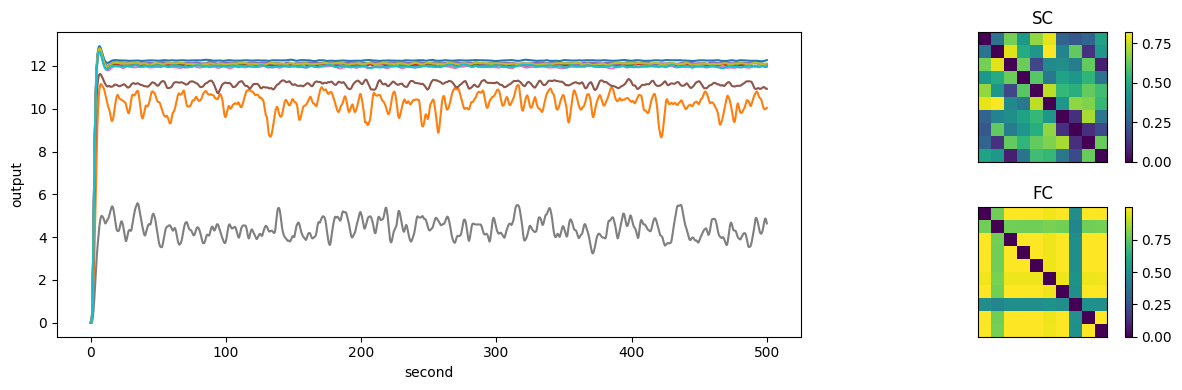

In [8]:
# plotting
fig = plt.figure(figsize=(12,4))

ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2, colspan=2)
ax1.plot(ts , out_data )
ax1.set_ylabel('output')
ax1.set_xlabel('second')

ax2 = plt.subplot2grid((2, 3), (0, 2), rowspan=1, colspan=1)
img = ax2.imshow(sc)
ax2.set_title('SC')
ax2.set_xticks([])
ax2.set_yticks([])
plt.colorbar(img)

ax3 = plt.subplot2grid((2, 3), (1, 2), rowspan=1, colspan=1)
img = ax3.imshow(fc)
ax3.set_title('FC')
ax3.set_xticks([])
ax3.set_yticks([])
plt.colorbar(img)

plt.tight_layout()
plt.show()
